In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
# ============================================================================
# STEP 1: LOAD AND UNDERSTAND YOUR DATA
# ============================================================================

df = pd.read_csv('churn/Churn_Modelling.csv')

print("=" * 80)
print("INITIAL DATA EXPLORATION")
print("=" * 80)


print("\n1. Dataset Shape:")
print(f"   Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")

print("\n2. Column Types and Non-Null Counts:")
print(df.info())

print("\n3. First Few Rows:")
print(df.head())

print("\n4. Basic Statistics:")
print(df.describe())

print("\n5. Target Variable Distribution:")
print(df['Exited'].value_counts())
print(f"\nChurn Rate: {df['Exited'].mean():.2%}")


INITIAL DATA EXPLORATION

1. Dataset Shape:
   Rows: 10,002 | Columns: 14

2. Column Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
mem

In [ ]:
# ============================================================================
# STEP 2: DATA CLEANING AND EXPLORATION
# ============================================================================

print("\n" + "=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)

# Check for missing values
print("\n1. Missing Values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\n2. Duplicate Rows: {df.duplicated().sum()}")

# Identify column types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n3. Numeric Columns: {numeric_cols}")
print(f"\n4. Categorical Columns: {categorical_cols}")



DATA QUALITY CHECKS

1. Missing Values:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

2. Duplicate Rows: 2

3. Numeric Columns: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

4. Categorical Columns: ['Surname', 'Geography', 'Gender']


In [ ]:
# ============================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Churn rate by categorical variables
print("\n1. Churn Rate by Geography:")
print(df.groupby('Geography')['Exited'].agg(['mean', 'count']))

print("\n2. Churn Rate by Gender:")
print(df.groupby('Gender')['Exited'].agg(['mean', 'count']))

print("\n3. Churn Rate by Number of Products:")
print(df.groupby('NumOfProducts')['Exited'].agg(['mean', 'count']))

# Correlation with target
print("\n4. Correlation with Churn (Top Features):")
correlations = df[numeric_cols].corrwith(df['Exited']).sort_values()
print(correlations.head(10))



EXPLORATORY DATA ANALYSIS

1. Churn Rate by Geography:
               mean  count
Geography                 
France     0.161548   5014
Germany    0.324701   2510
Spain      0.166734   2477

2. Churn Rate by Gender:
            mean  count
Gender                 
Female  0.250660   4544
Male    0.164712   5458

3. Churn Rate by Number of Products:
                   mean  count
NumOfProducts                 
1              0.277089   5085
2              0.076018   4591
3              0.827068    266
4              1.000000     60

4. Correlation with Churn (Top Features):
IsActiveMember    -0.156191
NumOfProducts     -0.047601
CreditScore       -0.026909
RowNumber         -0.016308
Tenure            -0.014117
HasCrCard         -0.007009
CustomerId        -0.006226
EstimatedSalary    0.012123
Balance            0.118456
Age                0.285318
dtype: float64



Generating visualizations...
✓ Saved: churn_eda_visualizations.png


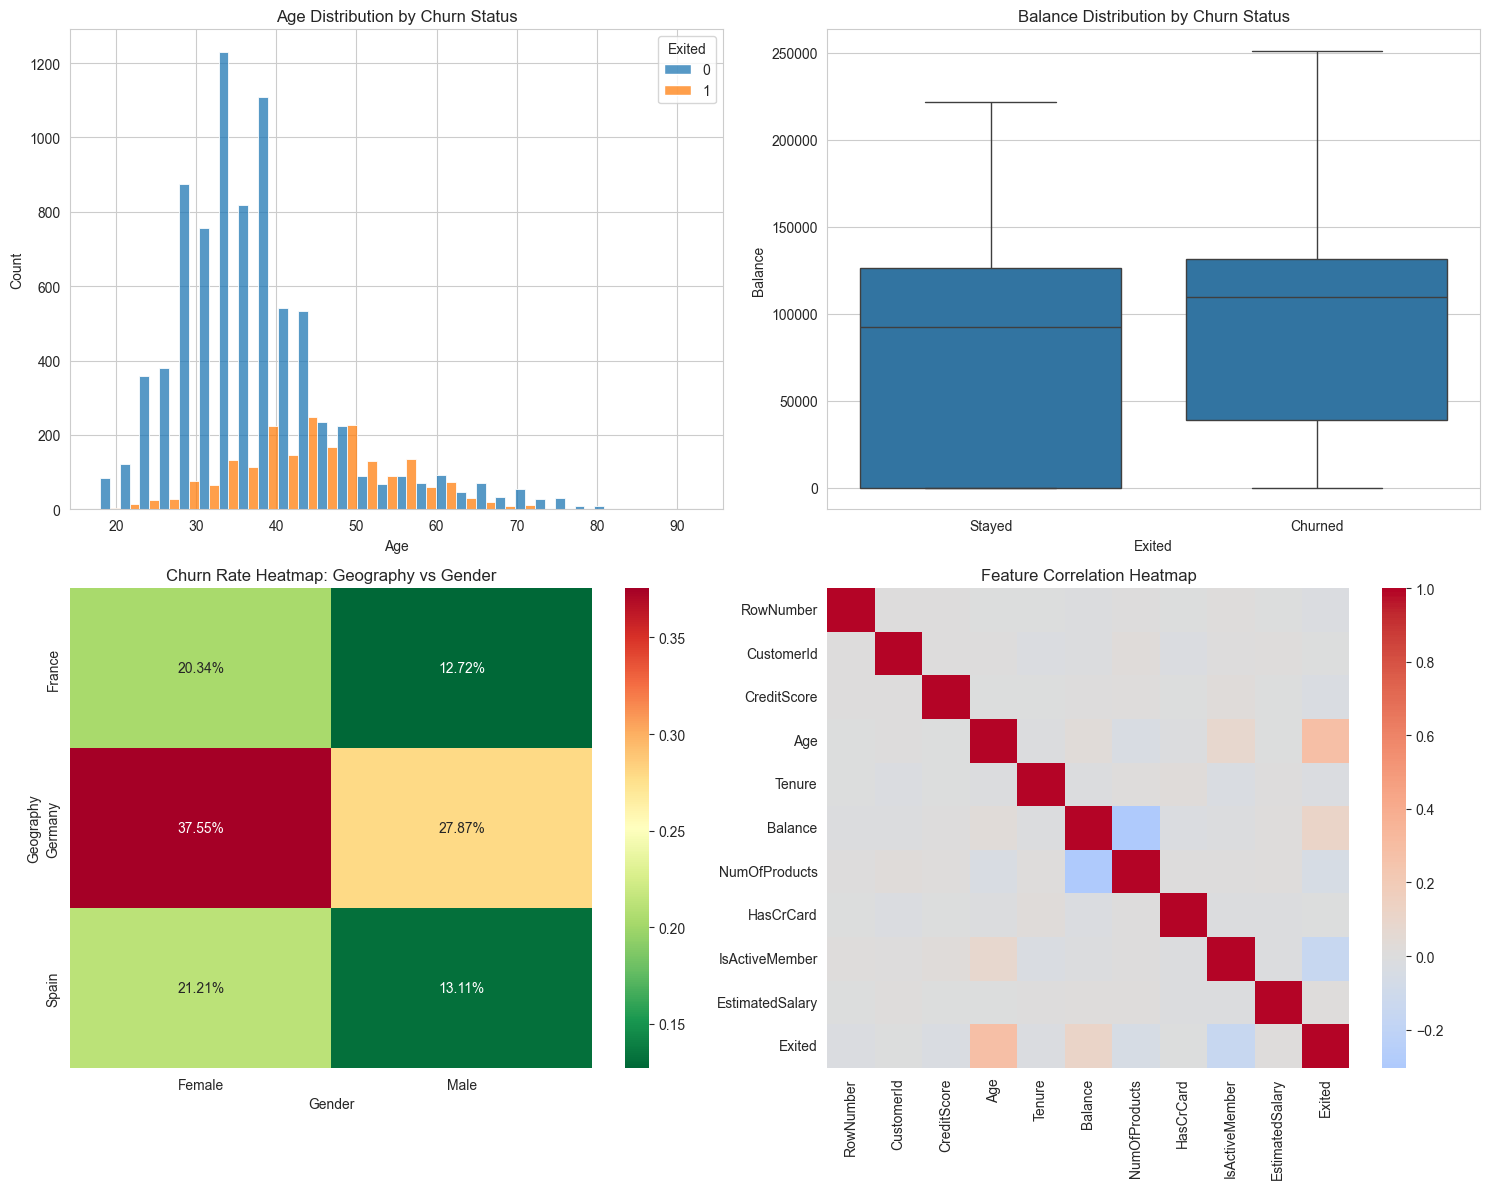


(Feature importance plot will be generated after model training)


In [28]:
# ============================================================================
# VISUALIZATION: This is where seaborn shines!
# ============================================================================

print("\nGenerating visualizations...")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Age distribution by churn
sns.histplot(data=df, x='Age', hue='Exited', multiple='dodge', bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution by Churn Status')
axes[0, 0].set_xlabel('Age')

# 2. Balance distribution by churn (using boxplot to see outliers)
sns.boxplot(data=df, x='Exited', y='Balance', ax=axes[0, 1])
axes[0, 1].set_title('Balance Distribution by Churn Status')
axes[0, 1].set_xticklabels(['Stayed', 'Churned'])

# 3. Churn rate by Geography and Gender
churn_geo_gender = df.groupby(['Geography', 'Gender'])['Exited'].mean().reset_index()
churn_pivot = churn_geo_gender.pivot(index='Geography', columns='Gender', values='Exited')
sns.heatmap(churn_pivot, annot=True, fmt='.2%', cmap='RdYlGn_r', ax=axes[1, 0])
axes[1, 0].set_title('Churn Rate Heatmap: Geography vs Gender')

# 4. Correlation heatmap of numeric features
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Feature Correlation Heatmap')

plt.tight_layout()
plt.savefig('churn_eda_visualizations.png', dpi=300, bbox_inches='tight')
print("✓ Saved: churn_eda_visualizations.png")
plt.show()

# Additional plot: Feature importance visualization (we'll update this after modeling)
print("\n(Feature importance plot will be generated after model training)")


In [ ]:
# ============================================================================
# STEP 4: FEATURE ENGINEERING
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Create a copy to avoid modifying original
df_model = df.copy()

# Example engineered features from static snapshot data
df_model['BalanceSalaryRatio'] = df_model['Balance'] / (df_model['EstimatedSalary'] + 1)
df_model['TenureAgeRatio'] = df_model['Tenure'] / (df_model['Age'] + 1)
df_model['IsActiveMember_HasCreditCard'] = df_model['IsActiveMember'] * df_model['HasCrCard']


In [ ]:
# ============================================================================
# STEP 5: DATA PREPARATION FOR ML
# ============================================================================

print("\n" + "=" * 80)
print("DATA PREPARATION")
print("=" * 80)

# Drop columns we don't need for modeling
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df_model = df_model.drop(columns=cols_to_drop)

# One-hot encode categorical variables
df_model = pd.get_dummies(df_model, columns=['Geography', 'Gender'], drop_first=True)

print(f"\n1. Shape after encoding: {df_model.shape}")
print(f"2. Features: {df_model.columns.tolist()}")

# Separate features and target
X = df_model.drop('Exited', axis=1)
y = df_model['Exited']

# Train-test split (80-20 is standard)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify keeps class balance
)

print(f"\n3. Training set: {X_train.shape[0]:,} samples")
print(f"   Test set: {X_test.shape[0]:,} samples")

# Scale features (important for many ML algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaling from training

print("\n4. Features scaled using StandardScaler")

In [ ]:
# ============================================================================
# STEP 6: MODEL TRAINING
# ============================================================================

print("\n" + "=" * 80)
print("MODEL TRAINING")
print("=" * 80)

# Random Forest is a great starting point for classification
model = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Prevent overfitting
    min_samples_split=20,  # Minimum samples to split a node
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

print("\nTraining Random Forest Classifier...")
model.fit(X_train_scaled, y_train)
print("✓ Model trained successfully")

In [ ]:
# ============================================================================
# STEP 7: MODEL EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

# Predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Accuracy
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)

print(f"\n1. Accuracy:")
print(f"   Training: {train_score:.4f}")
print(f"   Testing: {test_score:.4f}")

# Classification Report (Precision, Recall, F1)
print(f"\n2. Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Stayed', 'Churned']))

# ROC-AUC Score (measures model's ability to distinguish classes)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n3. ROC-AUC Score: {roc_auc:.4f}")
print("   (1.0 = perfect, 0.5 = random guessing)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n4. Confusion Matrix:")
print(f"   True Negatives (Stayed correctly): {cm[0,0]:,}")
print(f"   False Positives (Predicted churn, but stayed): {cm[0,1]:,}")
print(f"   False Negatives (Predicted stay, but churned): {cm[1,0]:,}")
print(f"   True Positives (Churned correctly): {cm[1,1]:,}")

In [ ]:
# ============================================================================
# STEP 8: FEATURE IMPORTANCE
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE")
print("=" * 80)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

In [ ]:
# ============================================================================
# STEP 9: BUSINESS INSIGHTS
# ============================================================================

print("\n" + "=" * 80)
print("KEY INSIGHTS FOR BUSINESS")
print("=" * 80)

# High-risk churn segments
df['ChurnProbability'] = model.predict_proba(scaler.transform(X))[:, 1]
df['ChurnRisk'] = pd.cut(df['ChurnProbability'], 
                          bins=[0, 0.3, 0.7, 1.0], 
                          labels=['Low', 'Medium', 'High'])

print("\n1. Customer Risk Distribution:")
print(df['ChurnRisk'].value_counts())

print("\n2. High-Risk Customer Profile:")
high_risk = df[df['ChurnRisk'] == 'High']
print(f"   Average Age: {high_risk['Age'].mean():.1f}")
print(f"   Average Balance: ${high_risk['Balance'].mean():,.2f}")
print(f"   Average Tenure: {high_risk['Tenure'].mean():.1f} years")
print(f"   Active Members: {high_risk['IsActiveMember'].mean():.1%}")